In [4]:
import pandas as pd
import numpy as np

In [22]:
import os
from dotenv import load_dotenv

load_dotenv()

DATA_PATH = os.getenv("FILES_PATH")
IMAGES_PATH = os.path.join(DATA_PATH, "PNG", "content_based")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, extension="png", resolution=300):  # Función para guardar las figuras que se vayan generando
    img_path = os.path.join(IMAGES_PATH, fig_id + "." + extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(img_path, format=extension, dpi=resolution)

In [23]:
from matplotlib import pyplot as plt

# Configuración de parámetros de matplotlib

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [24]:
df = pd.read_csv(os.path.join(DATA_PATH, "CSV", "cleaned_content_based.csv"), low_memory=False)

# Content Based Filtering

El primer modelo que hemos creado ha sido un recomendador muy simple, basado en las películas y su popularidad, con un filtro del género de la película. Sin embargo, este sistema recomienda las mismas películas a todos los usuarios, por lo que si un usuario quiere recomendaciones sobre películas de Romance, siempre recibirá las mismas recomendaciones que otros usuarios que busquen ese mismo género.

En caso de que una persona quisiera conocer películas de un mismo director, actor o que tenga una trama similar a otra pero con diferentes géneros, el recomendador simple que hemos elaborado no serviría. Vamos a hacer dos tipos de recomendadores:

- Basado en el contenido de la descripción de la película
- Basado en los metadatos (director, actores, géneros...)

De esta forma desarrollaremos dos sistemas de recomendación superiores al que hicimos anteriormente.

## Basado en la descripción

Durante el procesamiento de los datos en _notebook_ EDA00, hicimos una característica que englobaba la reseña y el _tagline_ de las películas (en caso de haber _tagline_). A partir de esta descripción, podemos realizar un sistema de recomendación basado en la similaridad de las películas. Recordemos que en nuestro caso la característica que engloba todo se llama _**description**_.

In [25]:
df.head(3)

,id,genres,imdb_id,title,overview,description,popularity,vote_average,vote_count,cast,keywords,director,metadata
0,862,"['animation', 'comedy', 'family']",tt0114709,Toy Story,"Led by Woody, Andy's toys live happily in his ...","Led by Woody, Andy's toys live happily in his ...",21.946943,7.7,5415.0,"['tomhanks', 'timallen', 'donrickles']","['jealousi', 'toy', 'boy', 'friendship', 'frie...",['johnlasseter'],jealousi toy boy friendship friend rivalri boy...
1,8844,"['adventure', 'fantasy', 'family']",tt0113497,Jumanji,When siblings Judy and Peter discover an encha...,When siblings Judy and Peter discover an encha...,17.015539,6.9,2413.0,"['robinwilliams', 'jonathanhyde', 'kirstendunst']","['boardgam', 'disappear', ""basedonchildren'sbo...",['joejohnston'],boardgam disappear basedonchildren'sbook newho...
2,15602,"['romance', 'comedy']",tt0113228,Grumpier Old Men,A family wedding reignites the ancient feud be...,A family wedding reignites the ancient feud be...,11.712900,6.5,92.0,"['waltermatthau', 'jacklemmon', 'ann-margret']","['fish', 'bestfriend', 'duringcreditssting']",['howarddeutch'],fish bestfriend duringcreditssting waltermatth...


In [26]:
# df = df.dropna(subset="metadata")

Lo primero que vamos a realizar es una tokenización del texto, eliminando los _stopwords_ y después le vamos a pasar un _stemmer_ tras tokenizar el texto.

In [27]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import nltk
import re

stop_w = set(stopwords.words("english"))  # Stopwords
remove_non_alpha = lambda x: re.sub(r"[^a-zA-Z]", " ", x)  # Elimina aquello que no sean palabras
tokenize = lambda x: nltk.tokenize.word_tokenize(x)  # Tokeniza cada entrada
stemmer = SnowballStemmer("english")
stemmer_fn = lambda desc: " ".join([stemmer.stem(w) for w in desc if w.lower() not in stop_w])  # Paso de estandarización

In [28]:
for fn in (remove_non_alpha, tokenize, stemmer_fn):
    df["description"] = df["description"].transform(func=fn)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(analyzer="word", ngram_range=(1, 2), stop_words="english", min_df=0.)  # Redundancia de stopwords
tfidf_matrix = tfidf.fit_transform(df["description"])

In [30]:
tfidf_matrix.shape

(41348, 921231)

Como hemos utilizado _TfidfVectorizer_, vamos a computar la similaridad con el kernel lineal, ya que el producto interno nos dará como resultado la similaridad coseno. Utilizando el kernel lineal la computación será más rápida.

In [31]:
from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [32]:
indices_mapper = pd.Series(df.index, index=df["title"]).drop_duplicates()

In [33]:
movie = "Avengers: Age of Ultron"
idx = indices_mapper[movie]
print(idx)
scores = list(enumerate(cosine_sim[idx]))
scores = sorted(scores, key=lambda x: x[1], reverse=True)
scores = scores[0:11]
avengers_recom_idx = [s[0] for s in scores]
df["title"].iloc[avengers_recom_idx] 

24802


24802                              Avengers: Age of Ultron
25212                          Tarzan's Greatest Adventure
12142                                             Iron Man
26043                                           Calculator
14524                                           Iron Man 2
28308                                    A Deadly Adoption
19703                                           Iron Man 3
30229                                                Hawks
36107    Fittest On Earth (The Story Of The 2015 Reebok...
17811                                                Verbo
17109                  Behind Enemy Lines II: Axis of Evil
Name: title, dtype: object

Vemos que el recomendador funciona como se esperaba. Vamos a guardar los parámetros y a crear las funciones necesarias para el sistema.

In [34]:
import pickle

models_path = os.path.join(DATA_PATH, "models", "content_based")
os.makedirs(models_path, exist_ok=True)

with open(os.path.join(models_path, "tfidf_description_matrix.pickle"), "wb") as f:
    pickle.dump(cosine_sim, f, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
import ast
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
from dotenv import load_dotenv
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
import pickle
import numpy as np


load_dotenv()
DEFAULT_PATH = os.path.join(models_path, "tfidf_description_matrix.pickle")


def save_param_matrix(param_matrix, path=DEFAULT_PATH):
    """Saves parameter matrix
    Args:
        param_matrix (numpy ndarray): matriz de numpy que contiene la similaridad entre cada película
        path (str): ruta en la que guardar la matriz de parámetros
    """
    with open(path, "wb") as f:
        pickle.dump(param_matrix, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_param_matrix(path=DEFAULT_PATH):
    """Carga el modelo basado en descripción de tfidf
    Args:
        path (str): ruta en la que se encuentra el fichero con los parámetros
    Returns:
        param_matrix (numpy ndarray): matriz de numpy que contiene la similaridad entre cada película
    """
    
    with open(path, "rb") as f:
        param_matrix = pickle.load(f)
    return param_matrix


def preprocess_data(dataframe, col="description"):
    """Pre-procesamiento de los datos previo al entrenamiento.
    Args:
        dataframe (pandas DataFrame): DataFrame con la columna a procesar
        col (str): nombre de la columna sobre la que realizar el procesado. Default description
    Returns:
        dataframe (pandas DataFrame): datos procesados con nltk
    """
    
    stop_w = set(stopwords.words("english"))  # Selecciona los stopwords
    
    remove_non_alpha_fn = lambda x: re.sub(r"[^a-zA-Z]", " ", x)  # Elimina aquello que no sean palabras
    tokenize_fn = lambda x: nltk.tokenize.word_tokenize(x)  # Tokeniza cada entrada
    
    stemmer = SnowballStemmer("english")
    stemmer_fn = lambda desc: " ".join([stemmer.stem(w) for w in desc if w.lower() not in stop_w])  # Paso de estandarización

    # Aplica cada función a la columna
    for fn in (remove_non_alpha_fn, tokenize_fn, stemmer_fn):
        dataframe[col] = dataframe[col].transform(func=fn)
    return dataframe


def train_content_recommender(dataframe, preprocess_fn, col="description", count_vec=False):
    """Entrenamiento del recomendador
    Args:
        dataframe (pandas DataFrame): DataFrame con los datos para entrenar
        preprocess_fn (function): función que realiza el procesado de los datos previo al entrenamiento
        col (str): nombre de la columna sobre la que realizar el entrenamiento. Default description
        count_vec (bool): booleano que indica si se usa o no CountVectorizer. Default False
    Returns:
        param_matrix (numpy ndarray): matriz de numpy que contiene la similaridad entre cada película
    """

    if count_vec:
        dataframe[col] = dataframe[col].fillna("")
        count_vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2), min_df=0., stop_words="english")
        count_vec_matrix = count_vectorizer.fit_transform(dataframe[col])
        return cosine_similarity(count_vec_matrix, count_vec_matrix)
    processed_data = preprocess_fn(dataframe, col)
    tfidf = TfidfVectorizer(analyzer="word", ngram_range=(1, 2), stop_words="english", min_df=0.)  # Redundancia de stopwords
    tfidf_matrix = tfidf.fit_transform(processed_data[col])

    return linear_kernel(tfidf_matrix, tfidf_matrix)


def get_description_recommendation(movie, top_n=10, dataframe=df, preprocess_fn=preprocess_data, 
                                   col="description", count_vec=False, path=DEFAULT_PATH):
    """Recomendador basado en la descripción de películas
    Args:
        movie (str): títutlo de la película sobre la que realizará las recomendaciones
        top_n (int): número de películas que recomienda al usuario. Default 10
        dataframe (pandas DataFrame): DataFrame con los datos para entrenar y los títulos a recomendar
        preprocess_fn (function): función que realiza el procesado de los datos previo al entrenamiento
        col (str): nombre de la columna sobre la que realizar el entrenamiento en caso de ser necesario. Default description
        count_vec (bool): booleano que indica si se usa o no CountVectorizer en el entrenamiento. Default False
        path (str): ruta en la que se encuentra el fichero con los parámetros
    Returns:
        movies list (list): lista con los títulos de las top_n películas más similares
    """
    if not isinstance(movie, str):  # Aseguramos que el usuario introduzca una string y no indicamos que no es tipo str
        raise ValueError("Película no encontrada.")

    # Intentamos cargar los parámetros. En caso de no haberlos, realizamos el entrenamiento
    try:
        param_matrix = load_param_matrix(path)
    except:
        param_matrix = train_content_recommender(df, preprocess_fn, col, count_vec)
        save_param_matrix(param_matrix, path)

    mapper = pd.Series(dataframe.index, index=dataframe["title"]).drop_duplicates()  # Para mapear ids con títulos
    scores = np.argsort(param_matrix[mapper[movie]])[::-1]  # Obtiene los índices de las películas con mayor similaridad
    movie_indices = scores[1:top_n + 1] # Top_n películas más similares, eliminando a movie

    return list(dataframe["title"].iloc[movie_indices].values)

In [36]:
get_description_recommendation("Avengers: Age of Ultron")

["Tarzan's Greatest Adventure",
 'Iron Man',
 'Calculator',
 'Iron Man 2',
 'A Deadly Adoption',
 'Iron Man 3',
 'Hawks',
 'Fittest On Earth (The Story Of The 2015 Reebok CrossFit Games)',
 'Verbo',
 'Behind Enemy Lines II: Axis of Evil']

## Basado en metadatos

Hemos visto cómo funciona el recomendador basado en la descripción, utilizando el método de Tfidf. Ahora vamos a utilizar la columna que hicimos en el EDA01 para crear un recomendador basado en los metadatos como director, actores... Lo primero que haremos es rellenar los faltantes de la columna de metadatos, para evitar problemas en el cálculo de la matriz de similaridad.

In [37]:
df["metadata"] = df["metadata"].fillna("")

En este caso vamos a utilizar CountVectorizer porque queremos evitar que el director y los actores carezcan de peso a la hora de realizar las recomendaciones. Al usar CountVectorizer, es necesario que esta vez sí utilicemos la funcioón _cosine_similarity_ para calcular la similaridad de coseno.

In [39]:
count_vec = CountVectorizer(analyzer="word", ngram_range=(1, 2), min_df=0., stop_words="english")
count_vec_matrix = count_vec.fit_transform(df["metadata"])
param_matrix = cosine_similarity(count_vec_matrix, count_vec_matrix)

with open(os.path.join(models_path, "count_metadata_matrix.pickle"), "wb") as f:
    pickle.dump(param_matrix, f, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
indices_mapper = pd.Series(df.index, df["title"]).drop_duplicates()

In [41]:
movie = "The Dark Knight"
idx = indices_mapper[movie]
print(idx)
scores = list(enumerate(param_matrix[idx]))
scores = sorted(scores, key=lambda x: x[1], reverse=True)
scores = scores[0:11]
dark_recom_idx = [s[0] for s in scores]
df["title"].iloc[dark_recom_idx]

12040


12040               The Dark Knight
17358         The Dark Knight Rises
9809                  Batman Begins
14856    Batman: Under the Red Hood
26663       Kidnapping Mr. Heineken
1311                 Batman Returns
22437     Batman: Assault on Arkham
8964                         Shiner
8868                       Thursday
36258      Batman: The Killing Joke
4775          The Holcroft Covenant
Name: title, dtype: object

In [43]:
get_description_recommendation("The Dark Knight", col="metadata", count_vec=True, 
                               path=os.path.join(models_path, "count_metadata_matrix.pickle"))

['The Dark Knight Rises',
 'Batman Begins',
 'Batman: Under the Red Hood',
 'Kidnapping Mr. Heineken',
 'Batman Returns',
 'Batman: Assault on Arkham',
 'Shiner',
 'Thursday',
 'Batman: The Killing Joke',
 'Saheb Biwi Aur Gangster Returns']

## Mejora de las recomendaciones con ratio ponderado

Vemos que nuestro recomendador funciona correctamente, no obstante, las películas que recomienda no son necesariamente las más populares o con mejor valoración. Por ello, vamos a añadirle un filtrado en función del peso ponderado de IMDB, tal y como hicimos con nuestro recomendador simple.

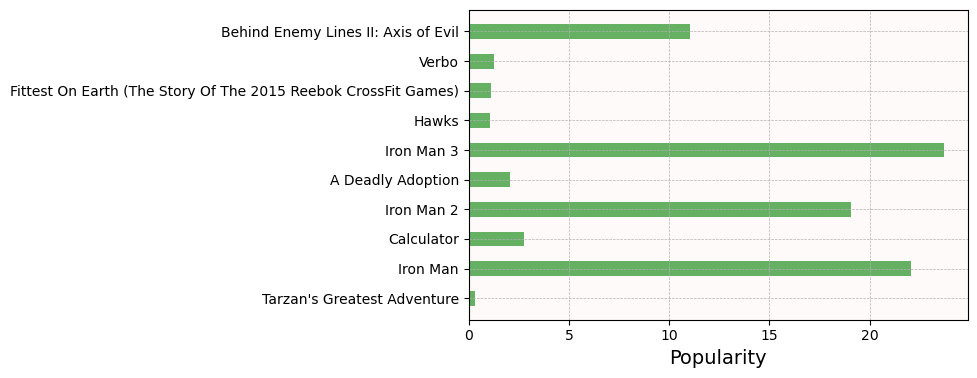

In [44]:
plt.figure(figsize=(10, 4))
titled_df = df.loc[avengers_recom_idx[1:]]
plt.barh(titled_df["title"], titled_df["popularity"], height=0.5, color="green", linewidth=0.5, alpha=0.6)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xlabel("Popularity")
plt.gca().set_facecolor("snow")
save_fig(f"age_of_ultron_description_recommendations")

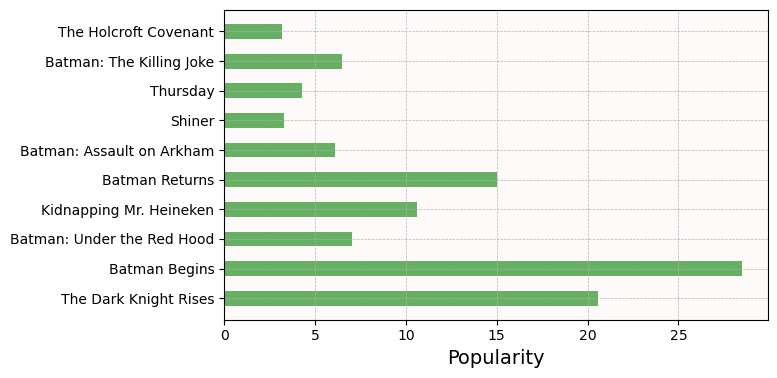

In [45]:
plt.figure(figsize=(8, 4))
titled_df = df.loc[dark_recom_idx[1:]]
plt.barh(titled_df["title"], titled_df["popularity"], height=0.5, color="green", linewidth=0.5, alpha=0.6)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.gca().set_facecolor("snow")
plt.xlabel("Popularity")
save_fig(f"dark_knight_metadata_recommendations")

In [46]:
def improved_recommendations(movie, q=0.6, top_n=25, dataframe=df, preprocess_fn=preprocess_data, 
                                   col="description", count_vec=False, path=DEFAULT_PATH):

    recommended_movies = get_description_recommendation(movie, top_n, dataframe, preprocess_fn, col, count_vec, path)
    recommended_df = dataframe[dataframe["title"].isin(recommended_movies)]
    
    def wr_func(data, C, m):
        v = data["vote_count"]
        R = data["vote_average"]
        return (v / (v + m) * R) + (m / (v + m) * C)
    
    # Cálculo de la puntuación ponderada
    C = recommended_df["vote_average"].mean()   
    m = recommended_df["vote_count"].quantile(q)
    recommended_df = recommended_df[recommended_df["vote_count"] > m]
    recommended_df["weighted_score"] = recommended_df.apply(wr_func, axis=1, C=C, m=m)
    
    return list(recommended_df.sort_values(by="weighted_score", ascending=False)["title"].values)

In [47]:
improved_recommendations("Avengers: Age of Ultron")

['Iron Man',
 'Iron Man 3',
 'Iron Man 2',
 'Gettysburg',
 'The Vikings',
 'The Music Man',
 'Knight and Day',
 "Mickey's House of Villains",
 'Pokémon Heroes: Latios and Latias']

In [49]:
improved_recommendations("The Dark Knight", col="metadata", count_vec=True, 
                               path=os.path.join(models_path, "count_metadata_matrix.pickle"))

['The Dark Knight Rises',
 'Batman Begins',
 'Batman: Under the Red Hood',
 'Batman: Assault on Arkham',
 'Batman Returns',
 'Thursday',
 'Batman & Mr. Freeze: SubZero',
 'Batman: The Killing Joke',
 'Kidnapping Mr. Heineken',
 'Batman & Robin']

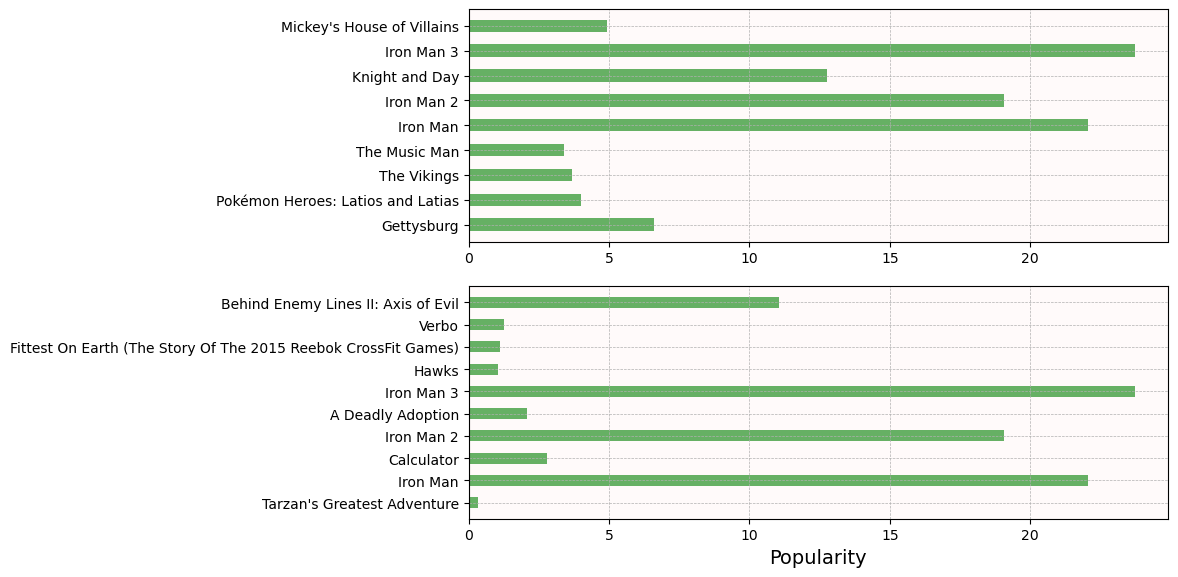

In [50]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
titled_df = df[df["title"].isin(improved_recommendations("Avengers: Age of Ultron"))]
plt.barh(titled_df["title"], titled_df["popularity"], height=0.5, color="green", linewidth=0.5, alpha=0.6)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.gca().set_facecolor("snow")
plt.subplot(212)
titled_df = df.loc[avengers_recom_idx[1:]]
plt.barh(titled_df["title"], titled_df["popularity"], height=0.5, color="green", linewidth=0.5, alpha=0.6)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xlabel("Popularity")
plt.gca().set_facecolor("snow")
save_fig(f"age_of_ultron_improved_recommendations")

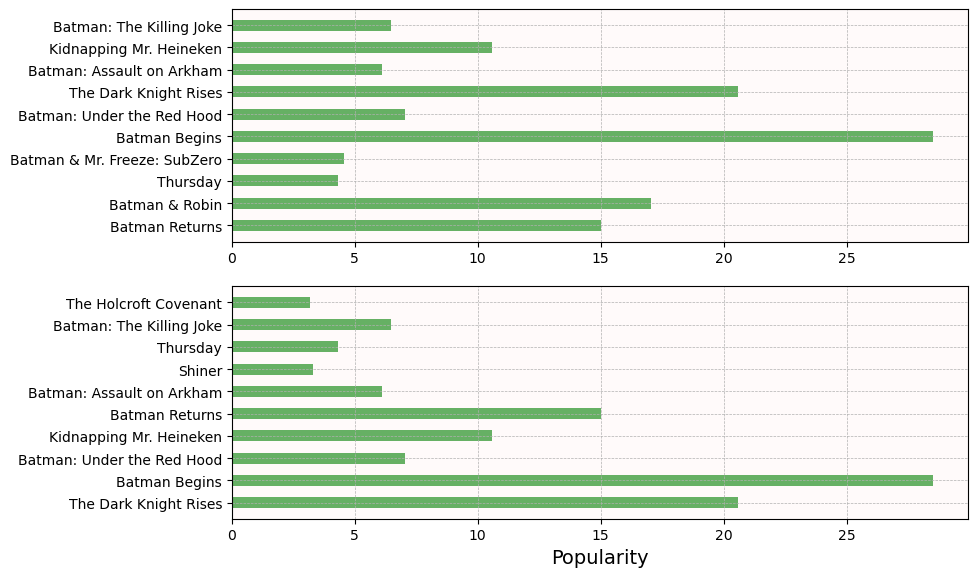

In [52]:
plt.figure(figsize=(10, 6))
plt.subplot(211)
titled_df = df[df["title"].isin(
    improved_recommendations("The Dark Knight", col="metadata", count_vec=True, 
                               path=os.path.join(models_path, "count_metadata_matrix.pickle"))
)]
plt.barh(titled_df["title"], titled_df["popularity"], height=0.5, color="green", linewidth=0.5, alpha=0.6)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.gca().set_facecolor("snow")
plt.subplot(212)
titled_df = df.loc[dark_recom_idx[1:]]
plt.barh(titled_df["title"], titled_df["popularity"], height=0.5, color="green", linewidth=0.5, alpha=0.6)
plt.grid(True, linestyle="--", linewidth=0.5)
plt.xlabel("Popularity")
plt.gca().set_facecolor("snow")
save_fig(f"dark_knight_improved_recommendations")